# Tau Data Analysis - Boosted Decision Trees

The following implementation is a baseline analysis script for the <b> SUSY tau+X </b> search. Based on this [paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.99.012009), a similar analysis strategy is being implemented. The general workflow, at this moment, is as follows:

<center>
    <img src="../Assets/General_Workflow.png" alt="Workflow" style="width: 50%"/>
</center>

The following script implements highly popular, powerful and widely recognized machine learning algorithm (especially in High-Energy Physics community) called <b> Boosted Decision Trees </b> (BDTs). An optimized distributed gradient boosting library called <b> XGBoost </b> has been implemented. XGBoost is an open-source library providing a dedicated regularizing gradient boosting framework.

As far as XGBoost is concerned, the following pipelines are functional:
* Regression
* Binary-classification
* Multiclass-classification

Other functionalities that have been implemented:
* Stopping function preventing overfitting
* Cross-validation
    * k-fold cross-validation
* Hyperparameters tuning:
    * randomized grid-search
    * exhaustive grid-search
* GPU computing

## Analysis

### Libraries

The following script relies on the following python packages.

ROOT I/O:

* [UpROOT](https://uproot.readthedocs.io/en/latest/)

Data Processing:

* [Awkward Array](https://awkward-array.readthedocs.io/en/latest/)
* [NumPy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)

Data Visualization:

* [Atlas MPL Style](https://atlas-mpl.readthedocs.io/en/latest/styles.html)
* [Matplotlib](https://matplotlib.org/)
* [Seaborn](https://seaborn.pydata.org/)

Machine Learning:

* [SciPy](https://scipy.org/)
* [SkLearn](https://scikit-learn.org/stable/)
* [XGBoost](https://xgboost.readthedocs.io/en/stable/)

Other:

* [tqdm](https://tqdm.github.io/)

In [65]:
import uproot as ur

import awkward as ak
import numpy as np
import pandas as pd

import atlas_mpl_style as ampl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from tqdm import tqdm
import pickle

import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

Applying ATLAS Style and supressing division by 0 warnings.

In [66]:
ampl.use_atlas_style()                  # ATLAS Style

import warnings
warnings.filterwarnings('ignore')       # Warnings supression

# plt.rc('text', usetex=True)           # LaTeX compatibility

In [67]:
#Uncomment the data type and classification type

DATA_TYPE = "low-level"
#DATA_TYPE = "high-level"
CUT = True

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M10"]
if (len(LABELS) > 2):
    ALGORITHM_TYPE = "multiclass-classification"
elif (len(LABELS) == 2):
    ALGORITHM_TYPE = "binary-classification"
else:
    print("Please input more than one label.")

TEST_LABELS = [f"{label}_test" for label in LABELS]
N_EVENTS = [50000, 25000]
TEST_N_EVENTS = [15000, 15000]
DATA_PATH = "/disk/atlas3/data_MC/delphes/"

#Set data paths

TRAIN_FILENAMES = [f"{label}_{n}events.root" for label, n in zip(LABELS, N_EVENTS)]
TEST_FILENAMES = [f"{label}_{n}events.root" for label, n in zip(LABELS, TEST_N_EVENTS)]

TRAIN_DATAPATHS = [f"{DATA_PATH}/{TRAIN_FILENAME}" for TRAIN_FILENAME in TRAIN_FILENAMES]
TEST_DATAPATHS = [f"{DATA_PATH}/{TEST_FILENAME}" for TEST_FILENAME in TEST_FILENAMES]

train_paths = ["/disk/atlas3/data_MC/delphes/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_10000events.root", 
"/disk/atlas3/data_MC/delphes/BH_n4_M10_10000events.root"]
test_paths = ["/disk/atlas3/data_MC/delphes/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_3000events.root", 
"/disk/atlas3/data_MC/delphes/BH_n4_M10_3000events.root"]

### Algorithm

There are three available pipelines depending on the type of the algorithm:
* Regression
* Binary-classification
* Multiclass-classification

In [68]:
def algorithm_definition(algorithm_type):
    """ 
    Algorithm type defining function. Parameters: algorithm_type: ('binary-classification', 'multiclass-classification').
    """
    
    if algorithm_type == 'binary-classification':
        backgrounds = ["SPH_9TeV", "BH_n4_M10"]
        labels = [
            r"SPH_9TeV",
            r"BH_n4_M10",
        ]
        print("Binary-classification initialized.")

    elif algorithm_type == 'multiclass-classification':
        backgrounds = ["BH_n4_M8", "BH_n4_M10","BH_n4_M12"]
        labels = [
            r"SPH_9TeV",
            r"BH_n4_M8",
            r"BH_n4_M10",
            r"BH_n4_M12"
        ]
        print("Multiclass-classification initialized.")
    else:
        raise Exception("Unsupported type of an algorithm. Only 'binary-classification' or 'multiclass-classification' allowed.")
    
    return algorithm_type, backgrounds, labels


algorithm_type, backgrounds, labels = algorithm_definition(ALGORITHM_TYPE)

Binary-classification initialized.


## Data

### Processing


Kinematic data (mainly momenta and related quantities) is heavily nested / jagged. Most of the ML algorithms do not work well with such complicated arrays. Hence, the rectangular format is preferred. The current solution is to set up a certain threshold for a number of entries each data entry can take and pad them with zeros.

In [69]:
def cut_5N_7ST(ar):
    ar["Jet.PT"] = ar["Jet.PT"][ar["Jet.PT"] > 70]
    ar["Jet.Eta"] = ar["Jet.Eta"][ar["Jet.Eta"] < 2.4]
    ar["Electron.PT"] = ar["Electron.PT"][ar["Electron.PT"] > 70]
    ar["Electron.Eta"] = ar["Electron.Eta"][ar["Electron.Eta"] < 2.4]
    ar["Muon.PT"] = ar["Muon.PT"][ar["Muon.PT"] > 70]
    ar["Muon.Eta"] = ar["Muon.Eta"][ar["Muon.Eta"] < 2.4]
    #ar["n_high_pt"] = 
    ar["n_jets"] = np.array([len(event) for event in ar["Jet.PT"]])
    ar["n_electrons"] = np.array([len(event) for event in ar["Electron.PT"]])
    ar["n_muons"] = np.array([len(event) for event in ar["Muon.PT"]])
    ar["N"] = ar["n_jets"] + ar["n_electrons"] + ar["n_muons"]
    sum_jet = ak.sum(ar["Jet.PT"], axis=-1)
    sum_muon = ak.sum(ar["Muon.PT"], axis=-1)
    sum_electron = ak.sum(ar["Electron.PT"], axis=-1)
    sum_met = ak.sum(ar["MissingET.MET"], axis=-1)
    ar["ST"] = sum_jet + sum_muon + sum_electron + sum_met
    ar = ar[ar["N"] > 5]
    ar = ar[ar["ST"] > 7000]
    return ar

In [70]:
# ---File Opening---
def load_low_level(paths, n_events):
    """
    Loads low-level data from calorimeters and the tracking system.
    """

    if CUT:
        keys = ["Event.Number", "Tower.Eta", "Tower.Phi", "Tower.Eem", 
            "Tower.Ehad", "Track.PT", "Track.Eta", "Track.Phi",
            "Jet.Eta", "Jet.PT", "Muon.PT", "Muon.Eta",
            "Electron.PT", "Electron.Eta", "MissingET.MET"]
    else:
        keys = ["Event.Number", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Track.PT", "Track.Eta", "Track.Phi"]
    
    ar = []

    # ---File Opening---
    for i, path in enumerate(paths):
        with ur.open(path) as temp_file:
                tree = temp_file['Delphes']
                ar_temp = tree.arrays(keys, library='ak')[0:n_events]
        ar_temp['background']=i
        ar = ak.concatenate([ar, ar_temp], axis=0)
    
   
    # ---Custom Parameters---
    n_max = 5                   # Number of most energetic particles to consider

    # Cuts
    if CUT:
        ar = cut_5N_7ST(ar)

    # ---Rename---
    ar["Ehad"] = ar["Tower.Ehad"]
    ar["Ehad.Eta"] = ar["Tower.Eta"]
    ar["Ehad.Phi"] = ar["Tower.Phi"]
    ar["Eem"] = ar["Tower.Eem"]
    ar["Eem.Eta"] = ar["Tower.Eta"]
    ar["Eem.Phi"] = ar["Tower.Phi"]
    ar["EventID"] = ar["Event.Number"]

    # ---Sort---
    ehad_idx = ak.argsort(ar["Ehad"], ascending=False, axis=-1)
    ar["Ehad"] = ar["Ehad"][ehad_idx]
    ar["Ehad.Eta"] = ar["Ehad.Eta"][ehad_idx]
    ar["Ehad.Phi"] = ar["Ehad.Phi"][ehad_idx]
    eem_idx = ak.argsort(ar["Eem"], ascending=False, axis=-1)
    ar["Eem"] = ar["Eem"][eem_idx]
    ar["Eem.Eta"] = ar["Eem.Eta"][eem_idx]
    ar["Eem.Phi"] = ar["Eem.Phi"][eem_idx]
    track_idx = ak.argsort(ar["Track.PT"], ascending=False, axis=-1)
    ar["Track.PT"] = ar["Track.PT"][track_idx]
    ar["Track.Eta"] = ar["Track.Eta"][track_idx]
    ar["Track.Phi"] = ar["Track.Phi"][track_idx]

    # ---Flattening---
    var_list = []
    for feat in ak.fields(ar):
        if (feat != "EventID"):
            try:                                        # Attempting to flatten features - catches all variable length features
                ak.flatten(ar[str(feat)],axis = 1)
                var_list.append(str(feat))              # Fields which need to be flattened and padded
            except Exception:
                ar = ar

    for feat in var_list:
        ar[feat] = ak.pad_none(ar[feat], target = n_max, clip = True)   # Padding
        for i in range(n_max):
            ar[f"{feat}_{i}"] = ar[feat][:,i]                           # Adding a new feature on the i'th element of var-length features
        ar = ar[[x for x in ak.fields(ar) if x != feat]]                # Removing jagged arrays

    # ---Conversion to Pandas---
    df = ak.to_pandas(ar)

    # ---Data Cleaning Execution---
    discard = ["Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Event.Number", "Jet.Eta", "Jet.PT", "Muon.PT", "Muon.Eta",
            "Electron.PT", "Electron.Eta", "MissingET.MET"] 
    for item in discard:
        df = df[df.columns.drop(list(df.filter(regex=item)))]
    return df

def load_high_level(paths, n_events):
    """"
    Loads high level features from the root file.
    """
    keys = ["Jet.Eta", "Jet.Phi", "Jet.PT", 
            "Muon.Eta", "Muon.Phi", "Muon.PT", 
            "Electron.Eta", "Electron.Phi", "Electron.PT", 
            "MissingET.MET", "MissingET.Eta"]
    ar = []
  # ---File Opening---
    for i, path in enumerate(paths):
        with ur.open(path) as temp_file:
                tree = temp_file['Delphes']
                ar_temp = tree.arrays(keys, library='ak')[0:n_events]
        ar_temp['background']=i
        ar = ak.concatenate([ar, ar_temp], axis=0)

    # ---Custom Parameters---
    n_max_jets = 8                   # Number of most energetic particles to consider
    nan_thresh = 0.10           # Threshold for keeping NaN-plagued features
    # ---Custom Parameters---
    jet_feats = ["Jet.Eta", "Jet.Phi", "Jet.PT"]
    for feat in jet_feats:
        ar[feat] = ak.pad_none(ar[feat], target = n_max_jets, clip = True)   # Padding
        for i in range(n_max_jets):
            ar[f"{feat}_{i}"] = ar[feat][:,i]                           # Adding a new feature on the i'th element of var-length features
        ar = ar[[x for x in ak.fields(ar) if x != feat]]              
    
    #CUT
    if CUT:
        ar = cut_5N_7ST(ar)

    n_max_leptons = 2
    lepton_feats = ["Muon.Eta", "Muon.Phi", "Muon.PT", "Electron.Eta", "Electron.Phi", "Electron.PT"]
    
    for feat in lepton_feats:
        ar[feat] = ak.pad_none(ar[feat], target = n_max_leptons, clip = True)   # Padding
        for i in range(n_max_leptons):
            ar[f"{feat}_{i}"] = ar[feat][:,i]                           # Adding a new feature on the i'th element of var-length features
        ar = ar[[x for x in ak.fields(ar) if x != feat]]              
    
    met_feats = ["MissingET.MET", "MissingET.Eta", "MissingET.Phi"]
    n_max_met = 1
    # ---Flattening Execution---
    for feat in met_feats:
        ar[feat] = ak.pad_none(ar[feat], target = n_max_met, clip = True)   # Padding
        for i in range(n_max_met):
            ar[f"{feat}_{i}"] = ar[feat][:,i]                           # Adding a new feature on the i'th element of var-length features
        ar = ar[[x for x in ak.fields(ar) if x != feat]]                # Removing jagged arrays
    # ---Flattening Execution---

    # ---Conversion to Pandas---
    df = ak.to_pandas(ar)
    return df


if DATA_TYPE=="low-level":
    df = load_low_level(TRAIN_DATAPATHS, 10000)
    test_df = load_low_level(TEST_DATAPATHS, 3000)

elif DATA_TYPE=="high-level":
    df = load_high_level(TRAIN_DATAPATHS, 10000)
    test_df = load_high_level(TEST_DATAPATHS, 3000)

else:
    print(f"{DATA_TYPE} is not a valid data type. It should be 'high-level' or 'low-level'")

### Preview

Previewing the processed rectangular data as a dataframe.

In [71]:
df.head()

,,background,n_jets,n_electrons,n_muons,N,ST,EventID,Ehad_0,Ehad_1,Ehad_2,...,Track.Eta_0,Track.Eta_1,Track.Eta_2,Track.Eta_3,Track.Eta_4,Track.Phi_0,Track.Phi_1,Track.Phi_2,Track.Phi_3,Track.Phi_4
entry,subentry,,,,,,,,,,,,,,,,,,,,,
0,0,0,7,0,0,7,7863.178223,2,1217.644897,439.961304,225.158569,...,-0.972547,0.157430,-0.460103,-0.462228,0.159489,-0.489829,1.175982,-2.987439,-2.985490,1.174006
1,0,0,7,0,0,7,7503.185547,13,1176.408081,651.740234,577.343201,...,0.542999,0.463940,-1.530482,-0.031219,0.460611,-2.257523,-3.026793,-0.501116,1.507495,-3.033484
2,0,0,6,0,1,7,7036.351562,14,988.688599,725.789978,511.926239,...,-1.086125,0.347694,0.123606,-0.410091,0.275401,-3.083340,-1.202558,1.335217,-0.285973,-1.432837
3,0,0,5,0,1,6,8248.565430,16,1319.777222,451.273285,269.420013,...,-0.526424,-0.214041,-0.212025,-0.593957,-0.242672,2.783611,-0.230347,-0.229209,-1.547321,-0.241041
4,0,0,8,1,0,9,7496.963379,17,568.879700,566.913208,534.717102,...,0.298111,-0.293040,-0.144323,0.679265,0.119608,0.139166,0.339745,-0.648714,-0.984497,-2.248650


In [72]:
test_df.head()

,,background,n_jets,n_electrons,n_muons,N,ST,EventID,Ehad_0,Ehad_1,Ehad_2,...,Track.Eta_0,Track.Eta_1,Track.Eta_2,Track.Eta_3,Track.Eta_4,Track.Phi_0,Track.Phi_1,Track.Phi_2,Track.Phi_3,Track.Phi_4
entry,subentry,,,,,,,,,,,,,,,,,,,,,
0,0,0,7,1,0,8,7492.708984,3,1763.527222,685.447205,353.050110,...,-0.352980,-0.292248,0.149823,0.150327,0.151714,3.019052,0.388007,-1.676672,-1.675867,-1.674279
1,0,0,8,1,0,9,7302.105469,4,1500.960693,1057.024780,690.706909,...,-0.243431,-0.162301,-0.243331,-0.046726,-0.038641,1.684573,-1.893748,1.685328,-0.343930,-0.359848
2,0,0,7,1,0,8,7060.675781,14,1046.696655,840.206787,769.806091,...,0.251060,-1.072553,0.531921,-0.568937,-0.569655,-3.008650,-0.326531,0.049227,0.744418,0.750809
3,0,0,8,1,0,9,7877.142090,15,1137.362305,982.506714,760.742188,...,-0.525647,-0.285315,0.066989,0.070787,0.072032,-0.993713,1.542500,-1.753928,-1.752363,-1.749589
4,0,0,8,1,1,10,7218.306152,22,689.367065,502.056580,459.186493,...,0.210150,-0.983248,-0.217060,-0.571007,0.338664,-0.448608,1.595736,0.244640,-1.905347,2.739513


### Shuffle

Shuffling the data to prevent any unnecessary correlations.

In [73]:
df = df.sample(frac=1)
df

,,background,n_jets,n_electrons,n_muons,N,ST,EventID,Ehad_0,Ehad_1,Ehad_2,...,Track.Eta_0,Track.Eta_1,Track.Eta_2,Track.Eta_3,Track.Eta_4,Track.Phi_0,Track.Phi_1,Track.Phi_2,Track.Phi_3,Track.Phi_4
entry,subentry,,,,,,,,,,,,,,,,,,,,,
2193,0,1,6,0,0,6,8876.144531,2072,2708.519287,651.487732,492.502899,...,-0.562581,0.275611,-0.562708,-0.561547,-0.561420,2.499276,-0.986700,2.500539,2.501083,2.502722
3077,0,1,5,1,1,7,7569.614746,5063,2646.115723,777.933472,561.797241,...,-1.137458,0.979017,-0.424655,0.687263,-0.184424,1.921075,0.179679,-2.044023,2.536530,-2.293501
4,0,0,8,1,0,9,7496.963379,17,568.879700,566.913208,534.717102,...,0.298111,-0.293040,-0.144323,0.679265,0.119608,0.139166,0.339745,-0.648714,-0.984497,-2.248650
3799,0,1,9,0,0,9,7385.020508,7518,896.792175,883.631836,849.973328,...,-0.605998,0.306097,0.290385,0.645343,0.301583,-1.118500,2.641410,2.624035,1.982873,2.642187
796,0,0,7,1,0,8,8116.777344,4959,524.184937,493.044647,440.548523,...,-0.015639,-0.035797,-0.061407,-0.085226,-0.371369,1.914515,-0.335024,-0.664925,-1.016634,-0.459160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,0,1,6,0,0,6,7366.435059,8201,1494.152222,1133.425293,1042.228760,...,0.345785,-0.276487,-0.047821,-0.046212,-0.262464,0.675993,-0.926349,-2.422345,-2.424748,-0.918060
3349,0,1,7,0,0,7,8408.774414,5995,1741.460693,1449.427124,461.386536,...,0.033363,0.505381,0.507421,0.604007,0.510643,1.610004,-1.544285,-1.550581,0.715600,-1.552503
2001,0,1,8,0,0,8,7183.056641,1390,2691.728516,1230.722290,731.253662,...,-0.615798,-1.347331,0.385018,-0.577217,0.383183,2.192831,-1.193435,-1.012578,2.284576,-1.009968


## Boosted Decision Trees

### Objective & Metric

Defining an objective and a metric.

In [74]:
def objective_metric_definition(algorithm_type):
    """ 
    Objective and metric definition function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification').
    """

    if algorithm_type == "binary-classification":
        objective = "binary:logistic"                   # Possibilities: binary:logistic, binary:logitraw, binary:hinge
        metric = "logloss"                              # Possibilities: logloss, error, error@t, auc

    elif algorithm_type == "multiclass-classification":
        objective = "multi:softmax"                     # Possibilities: multi:softmax, multi:softprob
        metric = "mlogloss"                             # Possibilities: mlogloss, merror, auc
        
    else:
        raise Exception("Unsupported type of an algorithm. Only 'binary-classification' or 'multiclass-classification' allowed.")
    
    return objective, metric

objective, metric = objective_metric_definition(algorithm_type)

### Train-Test Split

Splitting the data into train and test subsets. Depending on the type of the algorithm, a label is determined as follows:
* for regression, the $y$-label is set according to the Fields_Target.py,
* for binary- and multiclass-classification, the $y$-label is set as the "background" feature.

In [75]:
print(algorithm_type)
def split_data_label(algorithm_type, df, split=False):
    
    if (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
        y = df['background']
        X = df.drop('background', axis = 1)
    
    if split==True:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size = 0.1, 
            random_state = 1,
        )
        return X_train, X_test, y_train, y_test
    else:
        return X, y
X_train, X_val, y_train, y_val = split_data_label(algorithm_type, df, split=True)
X_test, y_test = split_data_label(algorithm_type, test_df, split=False)

binary-classification


### Preview

Previewing the $ y $- and $ x $-subsets.

In [76]:
X_train.head()

,,n_jets,n_electrons,n_muons,N,ST,EventID,Ehad_0,Ehad_1,Ehad_2,Ehad_3,...,Track.Eta_0,Track.Eta_1,Track.Eta_2,Track.Eta_3,Track.Eta_4,Track.Phi_0,Track.Phi_1,Track.Phi_2,Track.Phi_3,Track.Phi_4
entry,subentry,,,,,,,,,,,,,,,,,,,,,
1402,0,6,0,1,7,7385.301758,8871,1262.874878,643.686157,291.955994,260.915009,...,-0.038868,-0.456632,0.821404,-0.145381,0.824296,0.489366,-2.377382,2.711781,-2.550753,2.711909
2321,0,5,0,2,7,8966.168945,2465,1423.805176,716.614868,460.790070,428.850250,...,0.168007,1.049689,0.543025,0.542509,-1.406043,-2.746995,3.076900,0.615993,0.616209,-0.627541
2092,0,6,1,0,7,10135.702148,1715,1523.516479,1277.447998,767.258545,691.573303,...,0.170616,-0.033055,0.539710,-0.053279,0.019814,-1.712333,-2.913787,0.049193,0.300070,1.909895
4365,0,7,0,0,7,8190.130859,9486,3276.302246,591.265747,364.241852,285.389313,...,0.373602,-1.037265,0.358927,0.828372,-0.681083,0.584641,-2.187656,0.155563,0.222100,0.340829
403,0,6,1,1,8,7369.759766,2519,1293.713135,980.803040,686.976746,629.650513,...,0.877043,-0.400879,0.118556,-1.128345,0.515311,-0.832442,-0.895948,0.945764,-2.457661,2.269255


In [77]:
y_train.head()

entry  subentry
1402   0           0
2321   0           1
2092   0           1
4365   0           1
403    0           0
Name: background, dtype: int64

### Model

#### Parameters

Defining the initial hyperparameter values.

In [78]:
hyperparameters = {
    # ---General Parameters---
    'booster':'gbtree',                     # type of model to run at each iteration
    # ---General Parameters---

    # ---Booster Parameters---
    'n_estimators':20000,                    # number of classifiers
    'learning_rate':0.001,                    # learning rate
    'max_depth':5,                          # the maximum depth of a tree
    'min_child_weight':1,                   # defines the minimum sum of weights in a child
    'gamma':0,                              # specifies minimum loss reduction to make a split
    'subsample':1.0,                        # defines random fraction of observations for each tree
    'colsample_bytree':1.0,                 # defines random fraction of columns for each tree
    'reg_alpha':0,                          # L1 regularization term on weights
    'reg_lambda':0,                         # L2 regularization term on weights
    'scale_pos_weight':1,                   # balance of positive and negative weights
    'max_delta_step':0,                     # tree’s weight estimation
    # ---Booster Parameters---

    # ---Learning Task Parameters---
    'objective':objective,                  # defines loss function to be minimized
    'tree_method':'gpu_hist',               # tree constructing method. Possibilities: hist, gpu_hist, approx, exact
    'gpu_id':0,                             # selects which GPU card to use (uncheck in case of not using gpu)
    'seed':1,                               # seed statistic number
    # ---Learning Task Parameters---

    # ---Multiclass Parameters---
    'num_class':len(np.unique(y_train))         # number of classes (for multiclass-classification only)
    # ---Multiclass Parameters---
}

if algorithm_type != 'multiclass-classification':
    del hyperparameters['num_class']

Defining the fit parameter values.

In [79]:
fit_parameters= {
    'X':X_train,
    'y':y_train,
    "eval_set" : [(X_train, y_train), (X_val, y_val)],
    'eval_metric':metric,
    'early_stopping_rounds':1000,
    'verbose':0
}

#### Fitting

Fitting the model with hyper-and fit-parameters.

In [80]:
if (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
    xgb_model = xgb.XGBClassifier(**hyperparameters)
else:
    raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

xgb_model.fit(**fit_parameters)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.001, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=20000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)

#### Prediction

Making the predictions and estimating prediction probabilities (the latter only for binary- and multiclass-classification).

In [81]:
predictions = xgb_model.predict(
    X_test, 
    ntree_limit=xgb_model.best_ntree_limit
)

predictions_proba = xgb_model.predict_proba(
    X_test,
    ntree_limit=xgb_model.best_ntree_limit
)


#### Loss

Plotting the loss with respect to the number of trees. The optimal tree number is established when there is no improvement in the loss for succeeding, specific number of trees determined in the stopping functionality preventing overfitting.

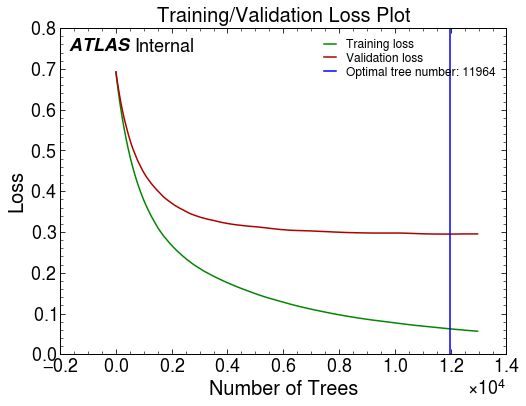

In [82]:
def loss_plotter(metric):
    """ 
    Loss plotting function. Parameters: metric ('string' - chosen metric for a given model).
    """

    fig, ax = plt.subplots(1,1, figsize=(8,6))

    ax.plot(xgb_model.evals_result()["validation_0"][metric], label="Training loss")
    ax.plot(xgb_model.evals_result()["validation_1"][metric], label="Validation loss")

    ax.axvline(xgb_model.best_ntree_limit , color="blue", label=f"Optimal tree number: {xgb_model.best_ntree_limit}")

    ax.set_xlabel("Number of Trees")
    ax.set_ylabel("Loss")

    ax.legend(loc="upper right", prop={'size': 12}, labelspacing=0.1, handlelength=1, handleheight=1)
    
    ax.set_title('Training/Validation Loss Plot')

    # ---ATLAS Label---
    ampl.draw_atlas_label(0.02, 0.97)
    # ---ATLAS Label---

    plt.show()

loss_plotter(metric)

#### Feature Importance

Plotting the feature importance score for all or specific amount of features.

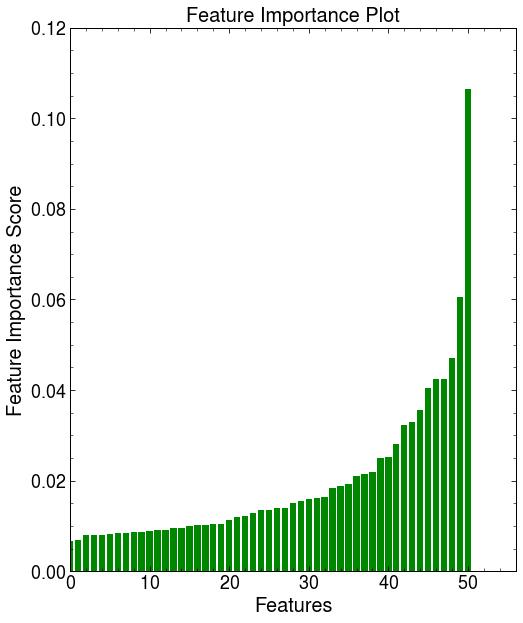

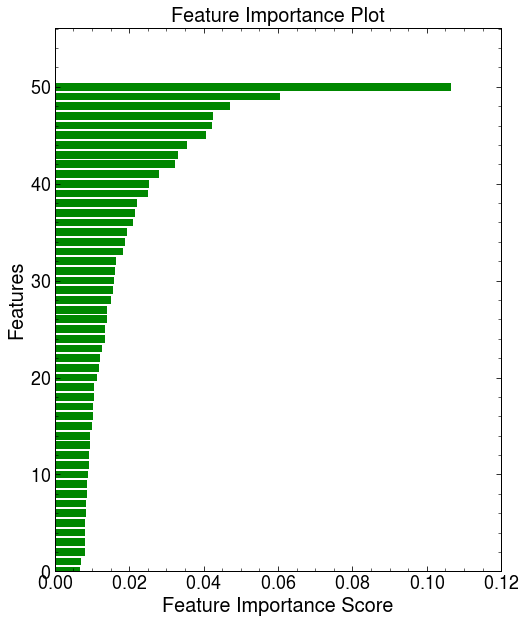

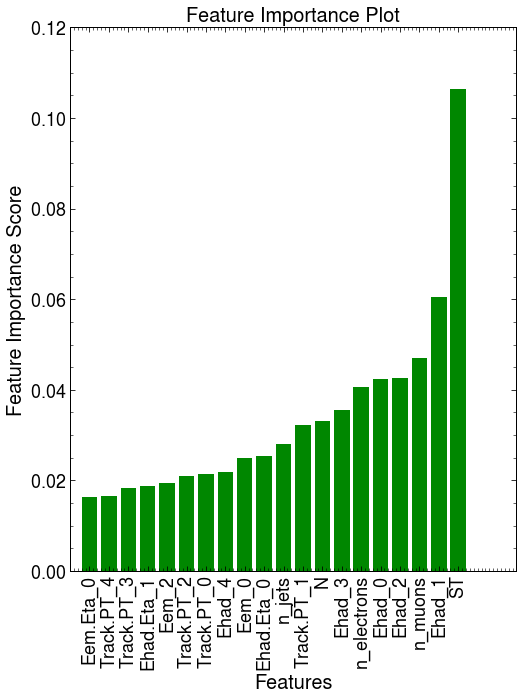

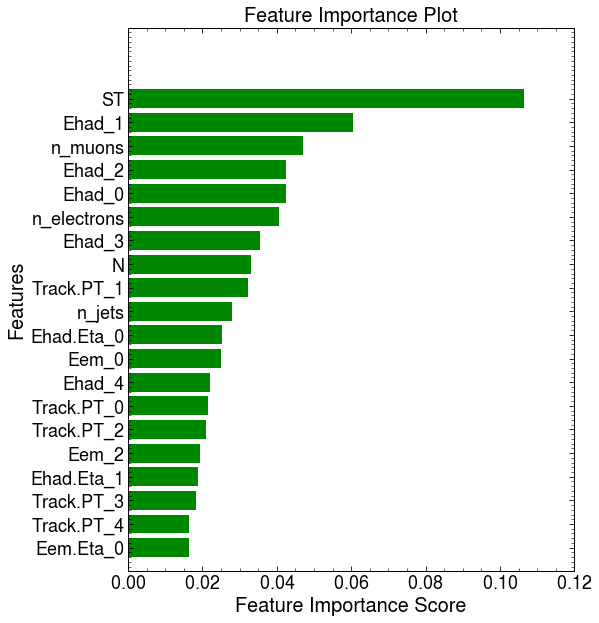

In [83]:
def feature_importance_plotter(direction, n=None):
    """ 
    Feature importance plotting function. Parameters: direction ('vertical', 'horizontal'), n (none - all features to print, integer - number of features to print).
    """

    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)

    if direction == 'vertical' and n == None:
        fig, ax = plt.subplots(1,1, figsize=(8,10))
        ax.bar(range(len(importances)), importances[indices])
        plt.xlim(0, len(importances) + 0.1*len(importances))
        ax.set_xlabel("Features")
        ax.set_ylabel("Feature Importance Score")
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 5))
    elif direction == 'horizontal' and n == None:
        fig, ax = plt.subplots(1,1, figsize=(8,10))
        ax.barh(range(len(importances)), importances[indices])
        plt.ylim(0, len(importances) + 0.1*len(importances))
        ax.set_xlabel("Feature Importance Score")
        ax.set_ylabel("Features")
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, 5))

    elif direction == 'vertical' and n:
        fig, ax = plt.subplots(1,1, figsize=(n*0.4, 10))
        ax.bar(range(0,n), importances[indices][-1:-n-1:-1][::-1])
        plt.xlim(-1, len(importances[indices][-1:-n-1:-1][::-1]) + 0.1*len(importances[indices][-1:-n-1:-1][::-1]))
        ax.set_xticks(range(0,n))
        ax.set_xticklabels(np.array(X_train.columns)[indices][-1:-n-1:-1][::-1])
        plt.xticks(rotation='vertical')
        ax.set_xlabel("Features")
        ax.set_ylabel("Feature Importance Score")
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 5))
    elif direction == 'horizontal' and n:
        fig, ax = plt.subplots(1,1, figsize=(8, n*0.5))        
        ax.barh(range(0,n), importances[indices][-1:-n-1:-1][::-1])
        plt.ylim(-1, len(importances[indices][-1:-n-1:-1][::-1]) + 0.1*len(importances[indices][-1:-n-1:-1][::-1]))
        ax.set_yticks(range(0,n))
        ax.set_yticklabels(np.array(X_train.columns)[indices][-1:-n-1:-1][::-1])
        ax.set_xlabel("Feature Importance Score")
        ax.set_ylabel("Features")
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, 5))

    else:
        raise Exception("Unsupported type of a direction. Only 'vertical' or 'horizontal' allowed.")

    ax.set_title('Feature Importance Plot')


feature_importance_plotter('vertical')
feature_importance_plotter('horizontal')
feature_importance_plotter('vertical', 20)
feature_importance_plotter('horizontal', 20)

### Evaluation Metrics

#### Scores

Displaying obtained result scores.

In [84]:
def scores_printer(algorithm_type):
    """ 
    Scores printing function. Parameters: algorithm_type: ('binary-classification', 'multiclass-classification').
    """

    if algorithm_type == 'binary-classification':
        
        print(f"Accuracy Score: {np.round(accuracy_score(y_test, predictions)*100,2)}%")
        print(f"Precision Score: {np.round(precision_score(y_test, predictions)*100,2)}%")
        print(f"Recall Score: {np.round(recall_score(y_test, predictions)*100,2)}%")
        print(f"F1 Score: {np.round(f1_score(y_test, predictions)*100,2)}%")
        print(f"ROC AUC Score: {np.round(roc_auc_score(y_test, predictions_proba[:, 1])*100,2)}%")

    elif algorithm_type == 'multiclass-classification':

        print(f"Precision Score | Accuracy (Micro Average): {np.round(precision_score(y_test, predictions, average='micro')*100,2)}%")
        print(f"Precision Score | Macro Average: {np.round(precision_score(y_test, predictions, average='macro')*100,2)}%")
        print(f"Precision Score | Weighted Average: {np.round(precision_score(y_test, predictions, average='weighted')*100,2)}%")
        print(f"Recall Score | Accuracy (Micro Average): {np.round(recall_score(y_test, predictions, average='micro')*100,2)}%")
        print(f"Recall Score | Macro Average: {np.round(recall_score(y_test, predictions, average='macro')*100,2)}%")
        print(f"Recall Score | Weighted Average: {np.round(recall_score(y_test, predictions, average='weighted')*100,2)}%")
        print(f"F1 Score | Accuracy (Micro Average): {np.round(f1_score(y_test, predictions, average='micro')*100,2)}%")
        print(f"F1 Score | Macro Average: {np.round(f1_score(y_test, predictions, average='macro')*100,2)}%")
        print(f"F1 Score | Weighted Average: {np.round(f1_score(y_test, predictions, average='weighted')*100,2)}%")
        
    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

scores_printer(algorithm_type)

Accuracy Score: 89.74%
Precision Score: 91.47%
Recall Score: 92.66%
F1 Score: 92.06%
ROC AUC Score: 96.21%


#### Classification Report

Printing a classification report and a support (for binary- and multiclass-classification). A support is the number of entries each class has.

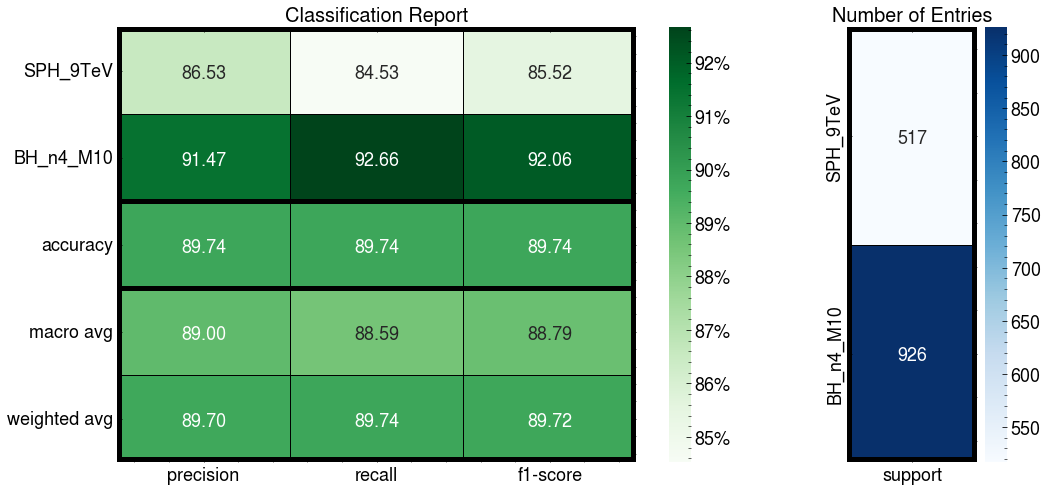

In [85]:
def classification_report_plotter(algorithm_type):
    """ 
    Classification report plotting function. Parameters: algorithm_type: ('binary-classification', 'multiclass-classification').
    """


    if (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
        

        clf_report = classification_report(
            y_test,
            predictions,
            labels=range(len(np.unique(df['background']))),
            target_names=labels,
            output_dict=True
        )

        fig, ax = plt.subplots(1,2, figsize=(16, 8), gridspec_kw={'width_ratios': [4, 1]})

        sns.heatmap(
            pd.DataFrame(clf_report).iloc[:-1, :].T*100,
            ax=ax[0],
            annot=True, 
            cmap='Greens',
            linewidth=0.5,
            linecolor='black',
            fmt='.2f', 
            annot_kws={"va": 'center_baseline'},
            cbar = True,
            cbar_kws={'format': '%.0f%%'}
        )

        ax[0].hlines(ax[0].get_ylim()[0], ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='black', lw=10)
        ax[0].hlines(ax[0].get_ylim()[1], ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='black', lw=10)
        ax[0].hlines([len(np.unique(df['background']))], ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='black', lw=5)
        ax[0].hlines([len(np.unique(df['background']))+1], ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='black', lw=5)
        ax[0].vlines(ax[0].get_xlim()[0], ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='black', lw=10)
        ax[0].vlines(ax[0].get_xlim()[1], ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='black', lw=10)

        ax[0].set_title('Classification Report')

        sns.heatmap(
            pd.DataFrame(clf_report).iloc[-1::, [x for x in (range(len(np.unique(df['background']))))]].T,
            ax=ax[1],
            annot=True, 
            cmap='Blues',
            linewidth=0.5,
            linecolor='black',
            fmt='.0f', 
            annot_kws={"va": 'center_baseline'},
            cbar = True,
            cbar_kws={'format': '%.0f'}
        )

        ax[1].hlines(ax[1].get_ylim()[0], ax[1].get_xlim()[0], ax[1].get_xlim()[1], color='black', lw=10)
        ax[1].hlines(ax[1].get_ylim()[1], ax[1].get_xlim()[0], ax[1].get_xlim()[1], color='black', lw=10)
        ax[1].vlines(ax[1].get_xlim()[0], ax[1].get_ylim()[0], ax[1].get_ylim()[1], color='black', lw=10)
        ax[1].vlines(ax[1].get_xlim()[1], ax[1].get_ylim()[0], ax[1].get_ylim()[1], color='black', lw=10)

        ax[1].set_title('Number of Entries')

        plt.show()
        
    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

classification_report_plotter(algorithm_type)

#### Confusion Matrix

Displaying a confusion matrix in terms of recall scoring (for binary- and multiclass-classification).

[[0.84526112 0.15473888]
 [0.07343413 0.92656587]]


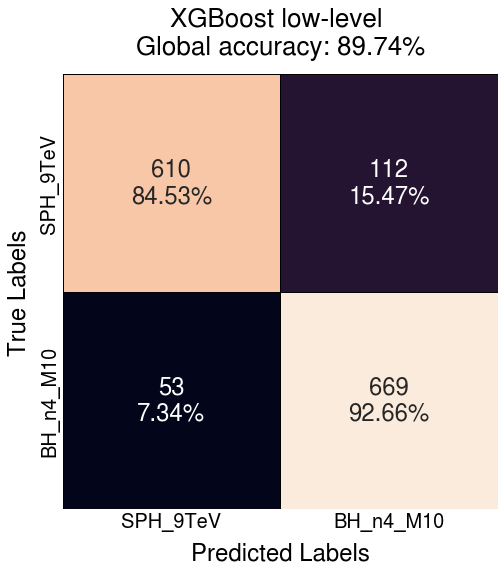

In [86]:
def confusion_matrix_plotter(algorithm_type):
    """ 
    Confusion matrix plotting function. Parameters: algorithm_type: ('binary-classification', 'multiclass-classification').
    """

    if algorithm_type == 'binary-classification':
        c_matrix = confusion_matrix(y_test, predictions, normalize="true")
        print(c_matrix)

        group_counts = ["{0:0.0f}".format(value*len(test_df)/2) for value in c_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten()]

        annot = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
        annot = np.asarray(annot).reshape(2,2)

        fig, ax = plt.subplots(1,1, figsize=(8, 8))
        sns.heatmap(
            c_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = False, 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'},
            annot_kws={"size": 24}
        )
        ax.set_title(f'XGBoost {DATA_TYPE} \nGlobal accuracy: {np.round(accuracy_score(y_test, predictions)*100,2)}%', size=26, pad=20)
        ax.xaxis.set_ticklabels(labels, size=20)
        ax.yaxis.set_ticklabels(labels, size=20)
        ax.set_ylabel('True Labels', size=24, labelpad = 10)
        ax.set_xlabel('Predicted Labels', size=24, labelpad= 10)
        ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        plt.show()

    elif algorithm_type == 'multiclass-classification':
        c_matrix = confusion_matrix(y_test, predictions, normalize="true")
        c_matrix_count = confusion_matrix(y_test, predictions)
        counts = np.array([int(x) for x in c_matrix_count.flatten()])
        percentages = []
        for x in range(len(np.unique(y_test))):
            percentages.append(c_matrix[x])
        percentages = np.array(percentages).flatten()
        percentages = np.array(list(map("{0:.2%}".format, percentages)))

        annot = [f"{v1}\n{v2}" for v1, v2 in zip(counts, percentages)]
        annot = np.asarray(annot).reshape(4,4)

        fig, ax = plt.subplots(1,1, figsize=(12, 12))

        sns.heatmap(
            c_matrix, 
            ax=ax, 
            annot=annot, 
            cbar = False,
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black', 
            square=True, 
            fmt='',
            annot_kws={"size": 24}
        )

        ax.set_title(f'XGBoost {DATA_TYPE} \nGlobal accuracy: {np.round(accuracy_score(y_test, predictions)*100,2)}%', size=26, pad=20)
        print(labels)
        ax.xaxis.set_ticklabels(labels, size=20)
        ax.yaxis.set_ticklabels(labels, size=20)
        ax.set_ylabel('True Labels', size=24)
        ax.set_xlabel('Predicted Labels', size=24)
        ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        
        plt.show()

    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")

confusion_matrix_plotter(algorithm_type)

In [87]:
model_preds = pd.DataFrame(dict(zip(["Truth", "Prediction"], [y_test, predictions])))
model_preds["EventID"] = test_df["EventID"]
df_wrong = model_preds[model_preds["Prediction"] != model_preds["Truth"]]

In [88]:
def save_wrong_predictions(truths, labels, eventids, savepath, filename):
    file = open(f"{savepath}/{filename}.csv", "w")
    file.write(f"Wrongly predicted events from datasets: {test_paths} by model XGBoost({ALGORITHM_TYPE}, {DATA_TYPE}")
    for i, truth in enumerate(truths):
        file.write(f"{labels[int(truth)]}, {int(eventids[i])}\n")
    file.close()
    
filename = f"XGBoost_{ALGORITHM_TYPE}_{DATA_TYPE}_wrongly_predicted"
save_wrong_predictions(df_wrong["Truth"].tolist(), labels, df_wrong["EventID"].tolist(), "../results/", filename)

#### ROC & PR Curve

Displaying a Receiver Operating Characteristic and Precision-Recall Curve (for binary- and multiclass-classification).

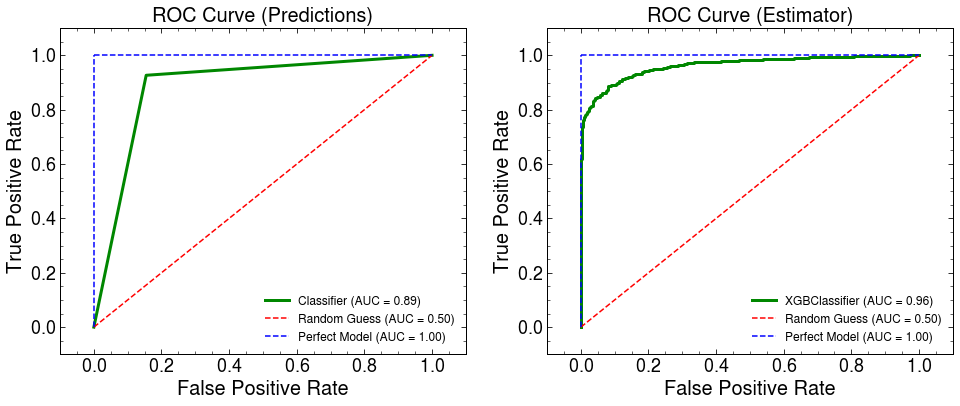

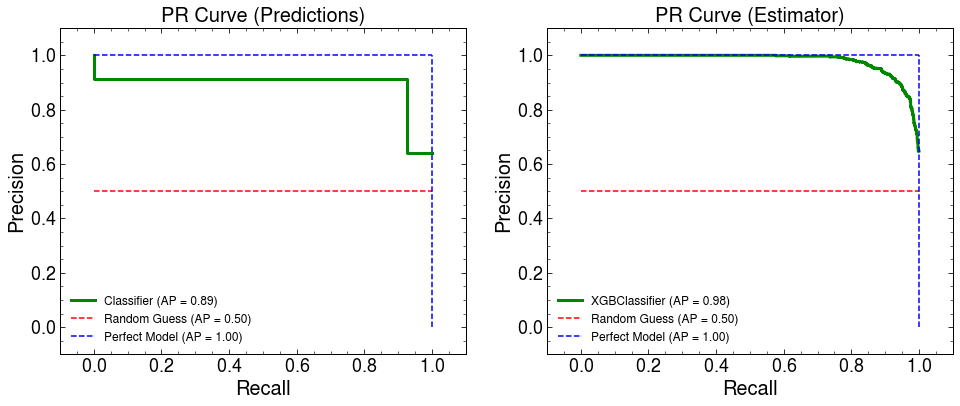

In [89]:
def curve_plotter(algorithm_type, curve_type):
    """ 
    ROC curve plotting function. Parameters: algorithm_type: ('binary-classification', 'multiclass-classification'), curve_type: ('roc' - receiver operating characteristic, 'pr' - precision recall).
    """

    if algorithm_type == 'binary-classification':
        fig, ax = plt.subplots(1,2, figsize=(16, 6))

        if curve_type == 'roc':
            
            
            RocCurveDisplay.from_predictions(y_test, predictions, ax=ax[0], linewidth=3)
            RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax[1], linewidth=3)

            ax[0].plot([0,1], [0,1], '--', color='red', label='Random Guess (AUC = 0.50)')
            ax[0].plot([0,0], [0,1], '--', color='blue', label='Perfect Model (AUC = 1.00)')
            ax[0].plot([0,1], [1,1], '--', color='blue')

            ax[1].plot([0,1], [0,1], '--', color='red', label='Random Guess (AUC = 0.50)')
            ax[1].plot([0,0], [0,1], '--', color='blue', label='Perfect Model (AUC = 1.00)')
            ax[1].plot([0,1], [1,1], '--', color='blue')

            ax[0].set_title('ROC Curve (Predictions)')
            ax[0].set_xlabel('False Positive Rate')
            ax[0].set_ylabel('True Positive Rate')

            ax[1].set_title('ROC Curve (Estimator)')
            ax[1].set_xlabel('False Positive Rate')
            ax[1].set_ylabel('True Positive Rate')

        elif curve_type == 'pr':
            

            PrecisionRecallDisplay.from_predictions(y_test, predictions, ax=ax[0], linewidth=3)
            PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax[1], linewidth=3)

            ax[0].plot([0,1], [0.5,0.5], '--', color='red', label='Random Guess (AP = 0.50)')
            ax[0].plot([1,1], [0,1], '--', color='blue', label='Perfect Model (AP = 1.00)')
            ax[0].plot([0,1], [1,1], '--', color='blue')

            ax[1].plot([0,1], [0.5,0.5], '--', color='red', label='Random Guess (AP = 0.50)')
            ax[1].plot([1,1], [0,1], '--', color='blue', label='Perfect Model (AP = 1.00)')
            ax[1].plot([0,1], [1,1], '--', color='blue')

            ax[0].set_title('PR Curve (Predictions)')
            ax[0].set_xlabel('Recall')
            ax[0].set_ylabel('Precision')

            ax[1].set_title('PR Curve (Estimator)')
            ax[1].set_xlabel('Recall')
            ax[1].set_ylabel('Precision')

        else:
            raise Exception("Unsupported type of a curve. Only 'roc' or 'pr' allowed.")

        ax[0].set_xlim([-0.1, 1.1])
        ax[0].set_ylim([-0.1, 1.1])
        ax[1].set_xlim([-0.1, 1.1])
        ax[1].set_ylim([-0.1, 1.1])

        ax[0].legend(fontsize=12)
        ax[1].legend(fontsize=12)

    elif algorithm_type == 'multiclass-classification':
        
        y_test_binarized = label_binarize(y_test, classes=np.arange(len(np.unique(y_test))))
        # y_test_binarized = label_binarize(y_test, classes=[*range(len(np.unique(y)))])

        fig, ax = plt.subplots(1,1, figsize=(9, 7))
        colors = sns.color_palette("Paired", n_colors = len(np.unique(y_test)))

        if curve_type == 'roc':
            from sklearn.metrics import roc_curve, auc

            fpr = dict()
            tpr = dict()

            roc_auc = dict()

            for i in range(len(np.unique(y_test))):
                fpr[i], tpr[i], _ = roc_curve(
                    y_test_binarized[:, i],
                    predictions_proba[:, i]
                )

                roc_auc = auc(
                    fpr[i], 
                    tpr[i]
                )

                plt.plot(
                    fpr[i], 
                    tpr[i], 
                    color=colors[i], 
                    label=f'{labels[i]} (AUC: {np.round(roc_auc, 2)})'
                )

            ax.plot([0,1], [0,1], '--', color='red', label='Random Guess (AUC = 0.50)')
            ax.plot([0,0], [0,1], '--', color='blue', label='Perfect Model (AUC = 1.00)')
            ax.plot([0,1], [1,1], '--', color='blue')

            ax.set_title('ROC Curve')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')

        elif curve_type == 'pr':
            from sklearn.metrics import precision_recall_curve, average_precision_score

            precision = dict()
            recall = dict()

            for i in range(len(np.unique(y_test))):
                precision[i], recall[i], _ = precision_recall_curve(
                    y_test_binarized[:, i],
                    predictions_proba[:, i]
                )

                ap = average_precision_score(
                    y_test_binarized[:, i], 
                    predictions_proba[:, i]
                )

                plt.plot(
                    recall[i], 
                    precision[i], 
                    color=colors[i],
                    label=f'{labels[i]} (AP: {np.round(ap, 2)})'
                )

            ax.set_title('PR Curve')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')

            ax.plot([0,1], [0.5,0.5], '--', color='red', label='Random Guess (AP = 0.50)')
            ax.plot([1,1], [0,1], '--', color='blue', label='Perfect Model (AP = 1.00)')
            ax.plot([0,1], [1,1], '--', color='blue')

        else:
            raise Exception("Unsupported type of a curve. Only 'roc' or 'pr' allowed.")
        
        leg = ax.legend(
            fontsize=12,
            bbox_to_anchor=(1.01, 1.015), 
            # loc='upper left', 
            # borderaxespad=0,
            frameon=True
        )
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(1.0)


        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])

    else:
        raise Exception("Unsupported type of an algorithm. Only 'regression', 'binary-classification' or 'multiclass-classification' allowed.")



    plt.show()

curve_plotter(algorithm_type, 'roc')
curve_plotter(algorithm_type, 'pr')

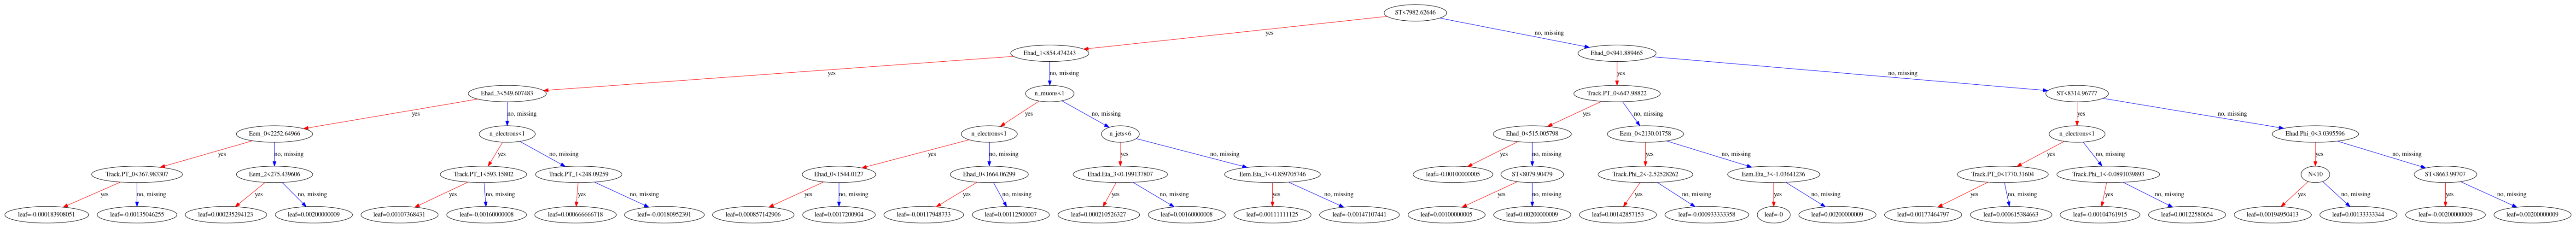

In [90]:
fig, ax = plt.subplots(figsize=(100, 30))
xgb.plot_tree(xgb_model, ax=ax)
plt.show()

In [91]:
# xgb_param = xgb_model.get_xgb_params()
# hyperparameters.update({'n_estimators': xgb_model.best_ntree_limit})

#### K-Fold Cross-Validation

Performing a K-Fold Cross-Validation with and without early-stopping-rounds (for binary- and multiclass-classification).

In [92]:
def k_fold_cross_validator(algorithm_type, k, stopping):
    """ 
    K-fold cross validating function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification'), k: (integer - number of folds), stopping (boolean - enable / disable early stopping round).
    """

    

    cv = RepeatedStratifiedKFold(
        n_splits=k,
        n_repeats=1,
        random_state=1
    )

    if (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
        scoring = 'accuracy'

        if stopping:
            fit_paramseters_cv = {
                "eval_set":[(X_train, y_train), (X_test, y_test)],
                'eval_metric':metric,
                'early_stopping_rounds':50,
                'verbose':0
            }

            xgb_cv = cross_val_score(
                estimator = xgb_model,
                X = X_train, y = y_train,
                cv = cv, 
                scoring = scoring,
                # n_jobs = -1,
                fit_params = fit_paramseters_cv
            )
            print(f"Mean {scoring} score equals {np.round(np.mean(xgb_cv)*100,2)}% for the {k}-folds with early-stopping-round functionality.")

        else:
            xgb_cv = cross_val_score(
                estimator = xgb_model,
                X = X_train, y = y_train,
                cv = cv, 
                scoring = scoring,
                # n_jobs = -1,
            )
            print(f"Mean {scoring} score equals {np.round(np.mean(xgb_cv)*100,2)}% for the {k}-folds without early-stopping-round functionality.")

    else:
        raise Exception("Unsupported type of an algorithm. Only 'binary-classification' or 'multiclass-classification' allowed.")

#k_fold_cross_validator(algorithm_type, 3, True)
#k_fold_cross_validator(algorithm_type, 3, False)

### Grid Search

Performing a grid search to find the best combination of parameter values (for binary- and multiclass-classification).

In [93]:
parameters_grid_randomized = {
    'n_estimators': [25, 50, 75, 100, 150, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 10, 15],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5, 10, 100],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1, 10, 25, 50, 100],
    'reg_lambda': [0, 0.1, 0.5, 1, 10, 25, 50, 100],
}

parameters_grid_exhaustive = {
    'n_estimators': [100, 250, 500, 750, 1000],
    'learning_rate': [0.05, 0.10],
    'max_depth': [4, 5, 6],
    # 'min_child_weight': [1, 5, 10],
    # 'gamma': [0.5, 1, 1.5, 2, 5, 10, 100],
    # 'subsample': [0.3, 0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'reg_alpha': [0, 0.1, 0.5, 1, 10, 25, 50, 100],
    # 'reg_lambda': [0, 0.1, 0.5, 1, 10, 25, 50, 100],
}


In [94]:
def grid_searcher(algorithm_type, kind, k):
    """ 
    Grid searching function. Parameters: algorithm_type: ('regression', 'binary-classification', 'multiclass-classification'), kind: ('randomized', 'exhaustive'), k: (integer - number of folds).
    """

    model_empty = xgb.XGBClassifier(
        tree_method = 'gpu_hist', 
        gpu_id = 0,
        random_state = 1
    )

    scoring = 'accuracy'

    fit_paramseters_cv = {
        "eval_set":[(X_train, y_train), (X_test, y_test)],
        'eval_metric':metric,
        'early_stopping_rounds':50,
        'verbose':0
    }

    
    if (algorithm_type == 'binary-classification') or (algorithm_type == 'multiclass-classification'):
        
        if kind == 'randomized':
            
            
            model_grid_randomized = RandomizedSearchCV(
                estimator = model_empty,
                param_distributions = parameters_grid_randomized,
                cv = k,
                scoring = scoring,
                random_state=1
                # n_jobs = -1,
            )

            model_grid_randomized_best = model_grid_randomized.fit(X_train, y_train, **fit_paramseters_cv)

            print(model_grid_randomized_best.best_params_)

        elif kind == 'exhaustive':
            

            model_grid_full = GridSearchCV(
                estimator = model_empty,
                param_grid = parameters_grid_exhaustive,
                cv = k,
                scoring = scoring,
                random_state=1
                # n_jobs = -1,
            )

            model_grid_full_best = model_grid_full.fit(X_train, y_train, **fit_paramseters_cv)

            print(model_grid_full_best.best_params_)

        else:
            raise Exception("Unsupported type of a grid. Only 'randomized' or 'exhaustive' allowed.")

    else:
        raise Exception("Unsupported type of an algorithm. Only 'binary-classification' or 'multiclass-classification' allowed.")

#grid_searcher(algorithm_type, 'randomized', 2)
# grid_searcher('exhaustive', 2)          # takes hell of a time...